# Comparison of chemical features

A comparisson of chemical features obtained in a molecule ussing smarts patterns and rdkit
feature factory.

In [1]:
import openpharmacophore.pharmacophore.pl_interactions as pli
from rdkit import RDConfig, Chem
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.AllChem import EmbedMultipleConfs
import numpy as np
import nglview as nv

from view_feats import add_features_to_view

from collections import defaultdict
import os

In [2]:
def get_chemical_features(molecule):
    """ Find chemical features in a molecule using rdkit feature factory.
    
        Returns
        -------
        dict[str, list[np.ndarray]]
    """
    features = defaultdict(list)
    # Use rdkit feature factory
    fdefName = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    featdef = ChemicalFeatures.BuildFeatureFactory(fdefName)
    chemical_features = featdef.GetFeaturesForMol(molecule)
    for feature in chemical_features:
        feat_name = feature.GetFamily()
        atom_indices = feature.GetAtomIds()
        if len(atom_indices) > 0:
            features[feat_name].append(atom_indices)

    return features


def get_feature_coords(ligand, atom_indices, conformer_index):
    """ Obtain the coordinates and if specified the directionality of a chemical feature.

        Parameters
        ----------
        ligand : rdkit.Chem.Mol
            A ligand

        conformer_index : int
            The conformer whose coordinates will be used to obtain the pharmacophoric
            points.

        Returns
        -------
        coords : np.ndarray of shape (3,)


    """
    if len(atom_indices) > 1:
        # Find the centroid
        # Aromatic, hydrophobic, positive or negative feature
        coords = _feature_centroid(ligand, atom_indices, conformer_index)
        # Find direction vector
    else:
        # Find the centroid
        # Donor or acceptor feature
        position = ligand.GetConformer(conformer_index).GetAtomPosition(atom_indices[0])
        coords = np.zeros((3,))
        coords[0] = position.x
        coords[1] = position.y
        coords[2] = position.z
    return coords


def _feature_centroid(molecule, atom_indxs, conformer_index):
    """
        Get the 3D coordinates of the centroid of a feature that encompasses more than
        one atom. This could be aromatic, hydrophobic, negative and positive features

        Parameters
        ----------
        molecule : rdkit.Chem.Mol
                Molecule that contains the feature which centroid will be computed

        atom_indxs : tuple of int
                Indices of the atoms that belong to the feature

        conformer_index : int
                Index of the conformer for which the feature centroid will be computed

        Returns
        -------
        centroid : numpy.ndarray of shape (3, )
            Array with the coordinates of the centroid of the feature.

    """

    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
        position = molecule.GetConformer(conformer_index).GetAtomPosition(idx)
        coords[j, 0] = position.x
        coords[j, 1] = position.y
        coords[j, 2] = position.z

    centroid = coords.mean(axis=0)

    return centroid


def features_centroid(features, molecule):
    """ Get the centroid of the features. """
    centroids = defaultdict(list)
    for feat_name, all_indices in features.items():
        for indices in all_indices:
            centroids[feat_name].append(get_feature_coords(molecule, indices, 0))
    
    return centroids
    

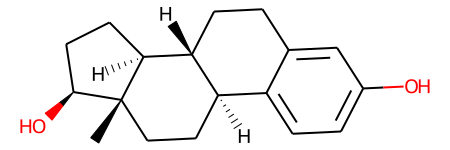

In [3]:
ligand = Chem.MolFromSmiles("C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O")
ligand

In [4]:
# Generate a conformer to visualize in 3D
ligand = Chem.AddHs(ligand)
EmbedMultipleConfs(ligand, 1)
ligand.GetNumConformers()

1

## Rdkit feature factory

In [5]:
rd_factory_feats_indices = get_chemical_features(ligand)
rd_factory_feats_center = features_centroid(rd_factory_feats_indices, ligand)

In [6]:
rd_factory_feats_center

defaultdict(list,
            {'Donor': [array([-4.31434157,  1.46806293,  0.30578931]),
              array([ 6.21400912,  0.27476309, -0.55121611])],
             'Acceptor': [array([-4.31434157,  1.46806293,  0.30578931]),
              array([ 6.21400912,  0.27476309, -0.55121611])],
             'Aromatic': [array([3.4812325 , 0.23486694, 0.11676157])],
             'Hydrophobe': [array([-2.43822886,  0.71161864, -1.45066069]),
              array([-2.07535356,  0.70016814,  0.0200952 ]),
              array([-1.22254293,  1.82364075,  0.4139686 ]),
              array([0.09803061, 1.55032859, 0.99986211]),
              array([0.70432263, 0.21651293, 0.81118092]),
              array([2.12620352, 0.20970865, 0.44409856]),
              array([2.94189617, 1.19019846, 0.93749936]),
              array([4.29969457, 1.21498978, 0.60917473]),
              array([ 4.00442577, -0.71522423, -0.69610551]),
              array([ 2.66048962, -0.74939604, -0.37801629]),
              array(

<strong>Note: The ligand has a donor and an acceptor with the same coordinates.</strong>

In [7]:
view_rd_factory = nv.show_rdkit(ligand)
add_features_to_view(view_rd_factory, rd_factory_feats_center, convert=False)
view_rd_factory

NGLWidget()

## Smart patterns

In [8]:
smarts_feat_indices = pli.chemical_features(ligand, pli.smarts_feat_def)
smarts_feat_centroid = features_centroid(smarts_feat_indices, ligand)

In [15]:
smarts_feat_indices

defaultdict(list,
            {'Donor': [(18,), (19,)],
             'Hydrophobe': [(0,), (1, 14, 15, 16, 17)],
             'Acceptor': [(18,), (19,)],
             'Aromatic': [(5, 6, 7, 8, 9, 10)]})

In [9]:
view_smarts = nv.show_rdkit(ligand)
add_features_to_view(view_smarts, smarts_feat_centroid, convert=False)
view_smarts

NGLWidget()

### Smart patterns from pharmer

In [10]:
smarts_pharmer = {'*([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])[CH3X4,CH2X3,CH1X2,F,Cl,Br,I]': 'Hydrophobe',
 'C(=O)N[OH1,O-,OX1]': 'NegIonizable',
 'C(=O)N[OH1,O-]': 'NegIonizable',
 'C(=O)[O-,OH,OX1]': 'NegIonizable',
 'CO(=N[OH1,O-])': 'NegIonizable',
 '[#16!H0]': 'Donor',
 '[#7!H0&!$(N-[SX4](=O)(=O)[CX4](F)(F)F)]': 'Donor',
 '[#7&!$([nX3])&!$([NX3]-*=[!#6])&!$([NX3]-[a])&!$([NX4])&!$(N=C([C,N])N)]': 'Acceptor',
 '[#8!H0&!$([OH][C,S,P]=O)]': 'Donor',
 '[$(*([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])[CH3X4,CH2X3,CH1X2,F,Cl,Br,I])&!$(*([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])[CH3X4,CH2X3,CH1X2,F,Cl,Br,I])]([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])[CH3X4,CH2X3,CH1X2,F,Cl,Br,I]': 'Hydrophobe',
 '[$(C(N)(N)=N)]': 'PosIonizable',
 '[$(CC)](=N)N': 'PosIonizable',
 '[$(N-[SX4](=O)(=O)[CX4](F)(F)F)]': 'NegIonizable',
 '[$([CH2X4,CH1X3,CH0X2]~[$([!#1]);!$([CH2X4,CH1X3,CH0X2])])]~[CH2X4,CH1X3,CH0X2]~[CH2X4,CH1X3,CH0X2]': 'Hydrophobe',
 '[$([CH2X4,CH1X3,CH0X2]~[CH2X4,CH1X3,CH0X2]~[$([CH2X4,CH1X3,CH0X2]~[$([!#1]);!$([CH2X4,CH1X3,CH0X2])])])]~[CH2X4,CH1X3,CH0X2]~[CH2X4,CH1X3,CH0X2]~[CH2X4,CH1X3,CH0X2]': 'Hydrophobe',
 '[$([CH3X4,CH2X3,CH1X2,F,Cl,Br,I])&!$(**[CH3X4,CH2X3,CH1X2,F,Cl,Br,I])]': 'Hydrophobe',
 '[$([O])&!$([OX2](C)C=O)&!$(*(~a)~a)]': 'Acceptor',
 '[$([S,P](=O)[O-,OH,OX1])]': 'NegIonizable',
 '[$([S]~[#6])&!$(S~[!#6])]': 'Hydrophobe',
 '[$(n1cc[nH]c1)]': 'PosIonizable',
 '[+,+2,+3,+4]': 'PosIonizable',
 '[-,-2,-3,-4]': 'NegIonizable',
 '[C&r3]1~[C&r3]~[C&r3]1': 'Hydrophobe',
 '[C&r4]1~[C&r4]~[C&r4]~[C&r4]1': 'Hydrophobe',
 '[C&r5]1~[C&r5]~[C&r5]~[C&r5]~[C&r5]1': 'Hydrophobe',
 '[C&r6]1~[C&r6]~[C&r6]~[C&r6]~[C&r6]~[C&r6]1': 'Hydrophobe',
 '[C&r7]1~[C&r7]~[C&r7]~[C&r7]~[C&r7]~[C&r7]~[C&r7]1': 'Hydrophobe',
 '[C&r8]1~[C&r8]~[C&r8]~[C&r8]~[C&r8]~[C&r8]~[C&r8]~[C&r8]1': 'Hydrophobe',
 '[CH2X4,CH1X3,CH0X2]~[CH3X4,CH2X3,CH1X2,F,Cl,Br,I]': 'Hydrophobe',
 'a1aaaa1': 'Aromatic',
 'a1aaaaa1': 'Aromatic',
 'c1[nH1]nnn1': 'NegIonizable',
 'c1nn[nH1]n1': 'NegIonizable',
}

In [11]:
pharmer_feat_indices = pli.chemical_features(ligand, smarts_pharmer)
pharmer_feat_centroid = features_centroid(pharmer_feat_indices, ligand)

In [12]:
view_pharmer = nv.show_rdkit(ligand)
add_features_to_view(view_pharmer, pharmer_feat_centroid, convert=False)
view_pharmer

NGLWidget()